## Gray-Wyner System Demo

Author: Cheuk Ting Li  

In [1]:
from psitip import *
PsiOpts.setting(
    solver = "ortools.GLOP",    # Set linear programming solver
    repr_latex = True,          # Jupyter Notebook LaTeX display
    venn_latex = True,          # LaTeX in diagrams
    proof_note_color = "blue",  # Reasons in proofs are blue
    solve_display_reg = True,   # Display claims in solve commands
    random_seed = 4321          # Random seed for example searching
)

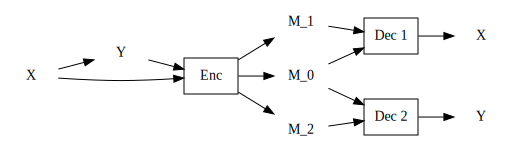

In [2]:
X, Y, U = rv("X, Y, U")
M0, M1, M2 = rv_array("M", 3)
R0, R1, R2 = real_array("R", 3)

model = CodingModel()         # Define Gray-Wyner system
model.set_rate(M0, R0)        # The rate of M0, M1, M2 are R0, R1, R2 resp.
model.set_rate(M1, R1)
model.set_rate(M2, R2)
model.add_edge(X, Y)          # X, Y are correlated source
model.add_node(X+Y, M0+M1+M2,
            label = "Enc")    # Encoder maps X,Y to M0,M1,M2
model.add_node(M0+M1, X,
            label = "Dec 1")  # Decoder 1 maps M0,M1 to X
model.add_node(M0+M2, Y,
            label = "Dec 2")  # Decoder 2 maps M0,M2 to Y

model.graph()                 # Draw diagram

In [3]:
r = model.get_inner()  # Automatic inner bound
r

( ( R_0 >= 0 )
 &( R_1 >= 0 )
 &( R_2 >= 0 )
 &( R_0+R_1 >= H(X)+I(A_M_0&Y|X) )
 &( R_0+R_2 >= H(Y)+I(A_M_0&X|Y) )
 &( R_0+R_1+R_2 >= H(X)+H(Y|A_M_0)+I(A_M_0&Y|X) ) ).exists(A_M_0)

In [4]:
# Although the above region does not look like the Gray-Wyner region [Gray-Wyner 1974],
#  they are actually equivalent.

# Write the Gray-Wyner region
r_gw = ((R0 >= I(X+Y&U)) & (R1 >= H(X|U)) & (R2 >= H(Y|U))).exists(U)
r_gw

( ( R_0 >= I(X+Y&U) )
 &( R_1 >= H(X|U) )
 &( R_2 >= H(Y|U) ) ).exists(U)

In [5]:
# Prove r is the same region as r_gw
print(bool(r >> r_gw))  # r implies r_gw
print(bool(r_gw >> r))  # r_gw implies r

True
True


In [6]:
# Automatic outer bound with 1 auxiliary, coincides with inner bound
model.get_outer(1)

( ( R_1 >= H(X|A) )
 &( R_2 >= H(Y|A) )
 &( R_0 >= I(A&X+Y) ) ).exists(A)

In [7]:
(model.get_outer() >> r).check_getaux_array()  # Converse proof, print auxiliary

CompArray(
[[A_M_0, X_P+M_0]])

In [8]:
# Output converse proof (is_proof = True for shorter proof)
# Lower search level to avoid modification to regions
with PsiOpts(auxsearch_level = 1):
    (model.get_outer(is_proof = True) >> r_gw).proof().display()

<IPython.core.display.Math object>

### Extremal Points and Corner Points

In [9]:
# Minimum sum rate is H(X, Y)
sumrate = r.minimum(R0 + R1 + R2, [R0, R1, R2])
sumrate

H(X+Y)

In [10]:
# Minimum weighted sum rate when R0 is counted twice is H(X)+H(Y)
wsumrate = r.minimum(R0 * 2 + R1 + R2, [R0, R1, R2])
wsumrate

H(X)+H(Y)

In [11]:
# Minimum symmetric rate
symrate = r.minimum(emax(R0, R1, R2), [R0, R1, R2])
symrate

(( universe() ).exists(A_M_0)).minimum(emax((1/2)*H(X)+(1/2)*I(A_M_0&Y|X), (1/2)*H(Y)+(1/2)*I(A_M_0&X|Y), (1/3)*H(X)+(1/3)*H(Y|A_M_0)+(1/3)*I(A_M_0&Y|X)))

In [12]:
# The corner point max R0 s.t. R0 + R1 = H(X), R0 + R2 = H(Y)
corner1 = (r & (R0 + R1 == H(X)) & (R0 + R2 == H(Y))).maximum(R0, [R0, R1, R2])
corner1

(( ( markov(A_M_0, X, Y) )
 &( markov(A_M_0, Y, X) ) ).exists(A_M_0)).maximum(I(A_M_0&Y))

In [13]:
# This is the Gacs-Korner common information [Gacs-Korner 1973]
bool(corner1 == gacs_korner(X & Y))

True

In [14]:
# The corner point min R0 s.t. R0 + R1 + R2 = H(X,Y)
corner2 = (r & (R0 + R1 + R2 == H(X+Y))).minimum(R0, [R0, R1, R2])
corner2

(( ( markov(X, A_M_0, Y) ) ).exists(A_M_0)).minimum(I(A_M_0&X+Y))

In [15]:
# This is Wyner's common information [Wyner 1975]
bool(corner2 == wyner_ci(X & Y))

True

In [16]:
# The corner point min R0 s.t. R0 + R2 = H(Y), R1 = H(X|Y)
corner3 = (r & (R0 + R2 == H(Y)) & (R1 == H(X|Y))).minimum(R0, [R0, R1, R2])
corner3

(( ( markov(X, A_M_0, Y) )
 &( markov(A_M_0, Y, X) ) ).exists(A_M_0)).minimum(I(A_M_0&Y))

In [17]:
# This is the necessary conditional entropy [Cuff-Permuter-Cover 2010] plus I(X;Y)
# We need the double Markov property [Csiszar-Korner 2011] to prove this
with dblmarkov().assumed():
    print(bool(corner3 <= H_nec(Y | X) + I(X & Y)))
    print(bool(corner3 >= H_nec(Y | X) + I(X & Y)))

True
True


### References
- A. El Gamal and Y.-H. Kim, _Network Information Theory_, Cambridge University Press, 2011, Ch. 14.
- R. M. Gray and A. D. Wyner, "Source coding for a simple network," Bell Syst. Tech. J., vol. 53, no. 9, pp. 1681–1721, 1974.
- P. Gács and J. Körner, "Common information is far less than mutual information," Problems Control Inf. Theory, vol. 2, no. 2, pp. 149–162, 1973.
- A. D. Wyner, "The common information of two dependent random variables," IEEE Trans. Inf. Theory, vol. IT-21, no. 2, pp. 163–179, Mar. 1975.
- P. W. Cuff, H. H. Permuter, and T. M. Cover, "Coordination capacity," IEEE Trans. Inf. Theory, vol. 56, no. 9, pp. 4181–4206, Sep. 2010.
- C. T. Li and A. El Gamal, "Extended Gray–Wyner system with complementary causal side information," IEEE Trans. Inf. Theory, vol. 64, no. 8, pp. 5862–5878, 2017
- I. Csiszár and J. Körner, "Information theory: coding theorems for discrete memoryless systems," Cambridge University Press, 2011.
